In [3]:
import jax
from jax import lax, random, numpy as jnp

import flax
from flax import linen as nn
from flax.training import train_state
from flax.core import freeze, unfreeze

import optax

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import functools
from typing import Any, Callable, Sequence, Optional

import numpy as np
import matplotlib.pyplot as plt


In [4]:
model = nn.Dense(features=10)

print(nn.Dense.__bases__)

(<class 'flax.linen.module.Module'>,)


In [5]:
seed = 42
key1, key2 = jax.random.split(jax.random.PRNGKey(seed))
x = jax.random.normal(key1, (10,))

y, params = model.init_with_output(key2, x)
print(y)
print(jax.tree.map(lambda x: x.shape, params))

2024-08-21 17:53:44.185425: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.1 which is older than the PTX compiler version (12.5.82). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


[ 0.02535915 -0.71720254  0.91523015 -0.26077026 -0.5085448   0.409678
 -0.06715219  1.5688229   0.05278341  1.7951217 ]
{'params': {'bias': (10,), 'kernel': (10, 10)}}


In [6]:
y = model.apply(params, x)
print(y)

[ 0.02535915 -0.71720254  0.91523015 -0.26077026 -0.5085448   0.409678
 -0.06715219  1.5688229   0.05278341  1.7951217 ]


In [34]:
seed = 23

n_samples = 1500
x_dim = 2
y_dim = 1
noise = 0.1

key, w_key, b_key = jax.random.split(jax.random.PRNGKey(seed), num=3)
w = jax.random.normal(w_key, (x_dim, y_dim))
b = jax.random.normal(b_key, (y_dim,))

params = freeze({'params': {'bias': b, 'kernel': w}})

key, x_key, noise_key = jax.random.split(key, num=3)
x = jax.random.normal(x_key, (n_samples, x_dim))
y = jnp.dot(x, w) + b + noise * jax.random.normal(noise_key, (n_samples, y_dim))

print(x.shape, y.shape)

(1500, 2) (1500, 1)


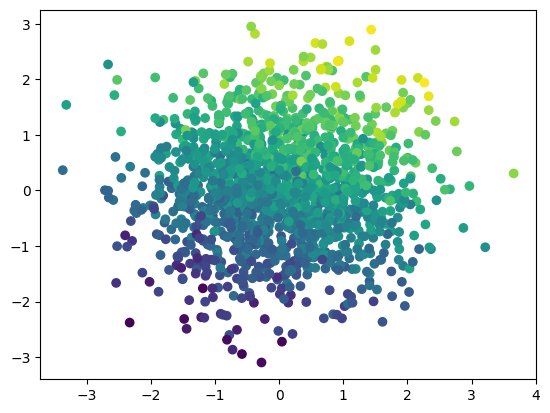

In [35]:
plt.scatter(x[:,0], x[:, 1], c=y)
plt.show()

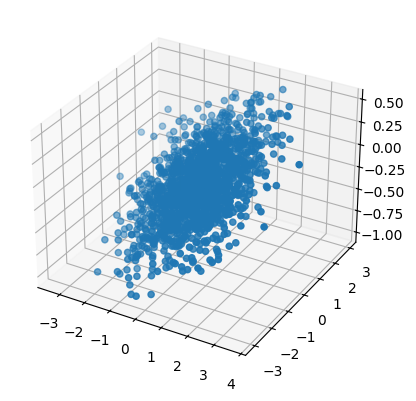

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=x[:, 0], ys=x[:, 1], zs=y[:,0])
plt.show()

In [38]:
@jax.jit
def mse_loss(params):
    def squared_error(x, y):
        pred = model.apply(params, x)
        return jnp.inner(y-pred, y-pred) / 2.0

    return jnp.mean(jax.vmap(squared_error), axis=0)

value_and_grad_loss = jax.value_and_grad(mse_loss)